In [289]:
# imports
import numpy as np
import scipy as scp
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linalg
import scipy.io
from scipy.ndimage.filters import gaussian_filter as gauss
import matplotlib.pylab as plt
import matplotlib as mpl

## 1 Bias and variance of ridge regression

## 2 Denoising of a CT image

In [209]:
# modified X generating function

def construct_X(M, alphas, Np = None, tau = 0, s0 = None, a0 = None, b0 = None):
    # convert to radians
    alphas = np.array(alphas)*np.pi*180**-1
    
    # number of pixels sensor
    if Np == None:
        Np = np.round(2**0.5*M)
        if Np%2 != 0:
            Np = Np+1

    if s0 == None:
        s0 = (Np-1)/2
        
    if a0 == None:
        a0 = -0.5*M
        
    if b0 == None:
        b0 = -0.5*M
      
    # number of orientations
    No = len(alphas)
    
    # center coordinates of pixel
    Jba = np.mgrid[:M,:M]
    C = np.array([Jba[1].ravel()+a0,Jba[0].ravel()+b0])
    
    # unit vector of orientation
    n = np.array([np.sin(alphas),np.cos(alphas)])
    
    # projection
    p = np.matmul(n.T,C) + s0
    
    # only use p when on the detector
    cond = np.array([np.logical_and(p>0,p<Np),np.logical_and(p>-1,p<Np-1)]).ravel()
    
    # indices
    Npio = Np*np.mgrid[:M**2,:No][1].T
    i_indices = np.array([p.astype(int)+Npio,np.round(p+0.5).astype(int)+Npio]).ravel() *cond
    #j_indices = np.array([np.arange(M**2) for i in range(2*No)]).ravel()*cond
    j_indices = np.array([Jba[1]+M*Jba[0]]*2*No).ravel()*cond
        
    # compute weights
    w1 = np.abs(p-p.astype(int))
    w2 = 1 - w1
    weights = np.array([w2,w1]).ravel()*cond

    shapeX = [int(Np*No), int(M**2)]

    # ridge regression
    if tau != 0:
        D = M**2
        shapeX = [int(Np*No)+D, int(M**2)]
        rr_indices = [int(Np*No)+np.arange(D), np.arange(D)]
        Tau = np.array([tau**0.5 for i in range(D)])
        
        # append to existing arrays
        weights = np.concatenate([weights,Tau])
        i_indices = np.concatenate([i_indices,rr_indices[0]])
        j_indices = np.concatenate([j_indices,rr_indices[1]])
        
        
    # generate X matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(shapeX[0],shapeX[1]), dtype = np.float32)
    
    return X

(-0.5, 99.5, 144.5, -0.5)

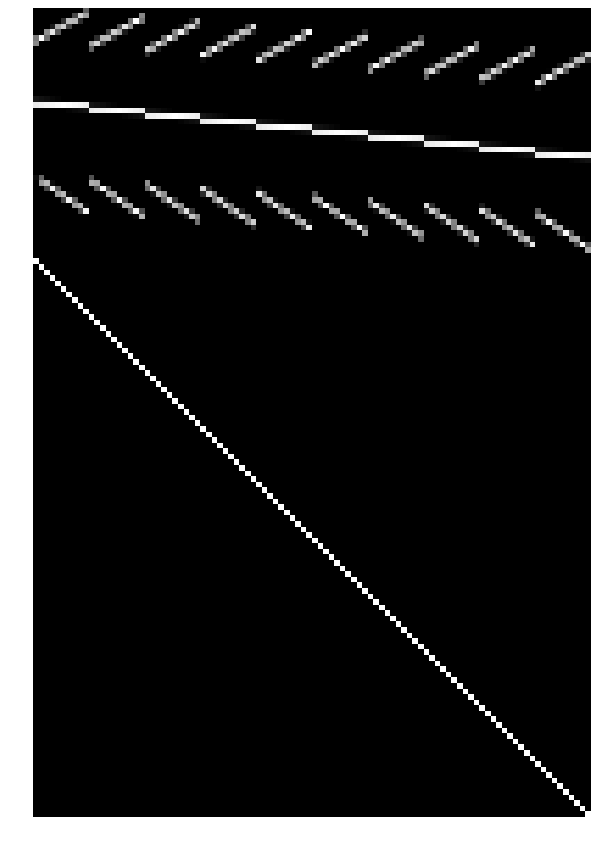

In [210]:
# test matrix generation
X = construct_X(10,np.array([-33,1,42,]),15,1).toarray()

plt.figure(figsize=[10,15])
plt.imshow(X,cmap='gray')
plt.axis('off')

In [ ]:
# image reconstruction

# read in data
alphas_195 = scp.load('hs_tomography/alphas_195.npy')
alphas_77 = scp.load('hs_tomography/alphas_77.npy')

y_195 = scp.load('hs_tomography/y_195.npy')
y_77 = scp.load('hs_tomography/y_77.npy')
X_77_sol = scp.load('hs_tomography/X_77.npy')[()]

In [262]:
# pick specified number of angles
n_projections = 64
Np = 275
index = [int(np.ceil(len(alphas_195) * p/n_projections)) for p in range(n_projections)]
alphas_sub = alphas_195[index]

# collect corresponding measurements from y
y_sub = []
for i in index:
    y_sub.extend(y_195[i*Np : (i+1)*Np])

In [269]:
# compute augmented matrix
Tau = [0,1e1,1e2,1e3,1e4,1e5,1e6]

X_aug = [construct_X(195,alphas_sub+90,275,t,137,-97,-97) for t in Tau]
y_aug = np.concatenate([y_sub,np.zeros(195**2)])

In [270]:
# small matrix
fitres = [linalg.lsqr(A=X_aug[0],b=y_sub,atol=1e-5,btol=1e-5)] + [linalg.lsqr(A=x,b=y_aug,atol=1e-5,btol=1e-5) for x in X_aug[1:]]
b = [f[0] for f in fitres]

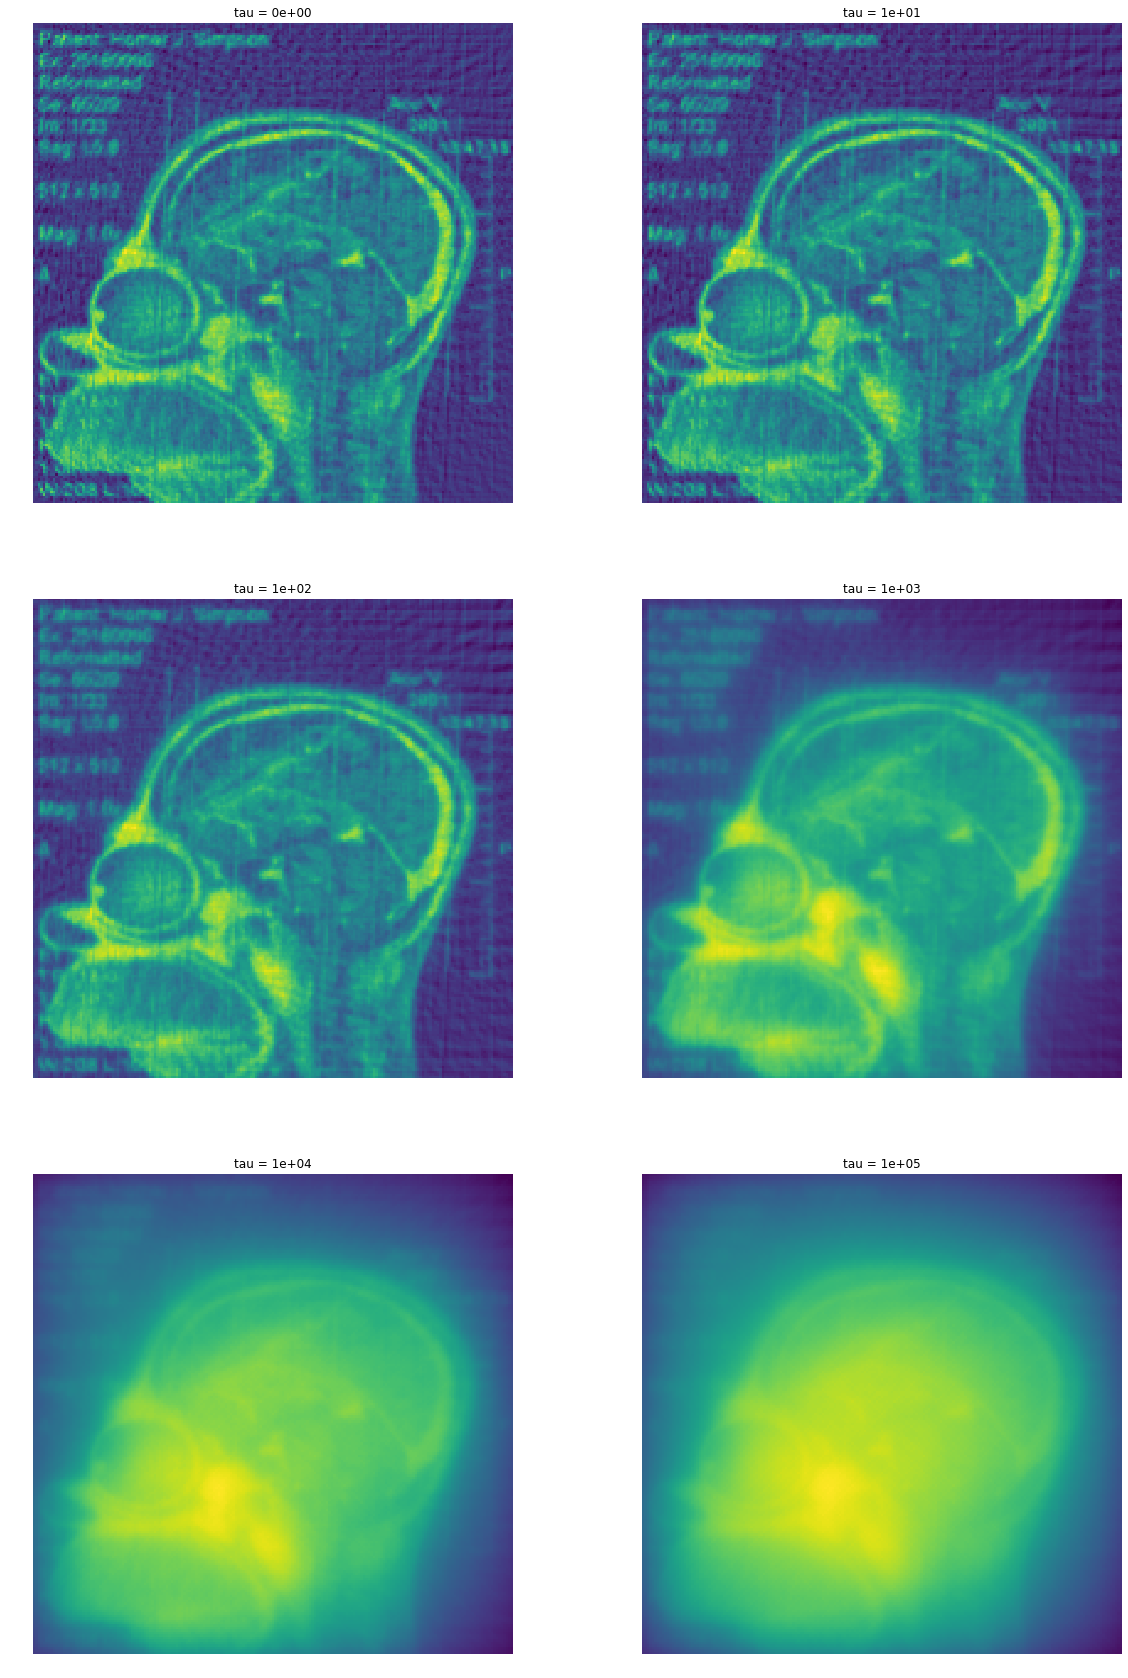

In [271]:
plt.figure(figsize=[20,30])
gs = mpl.gridspec.GridSpec(3, 2)

for i in range(6):
    plt.subplot(gs[i])
    plt.title('tau = %0.0e' %(Tau[i]))
    plt.imshow(b[i].reshape([195,195]))
    plt.axis('off')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'std image')

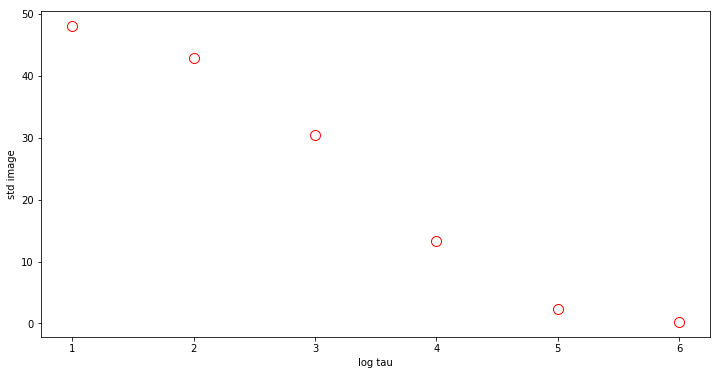

In [287]:
plt.figure(figsize=[12,6])
plt.scatter(np.log10(Tau),np.std(b,axis=1),s=100,facecolor='w',edgecolor='r')
plt.xlabel('log tau')
plt.ylabel('std image')

The standard deviation of pixels shrinks significantly for larger tau, which indicates the reduction of noise. A good trade off between sharpness and noise can be reached for tau inbetween 100 to 1000.

In [296]:
# gaussian filter
sigma = [1,2,3,5,7]
b_gauss = [b[0].reshape([195,195])] + [gauss(b[0].reshape([195,195]),s) for s in sigma]

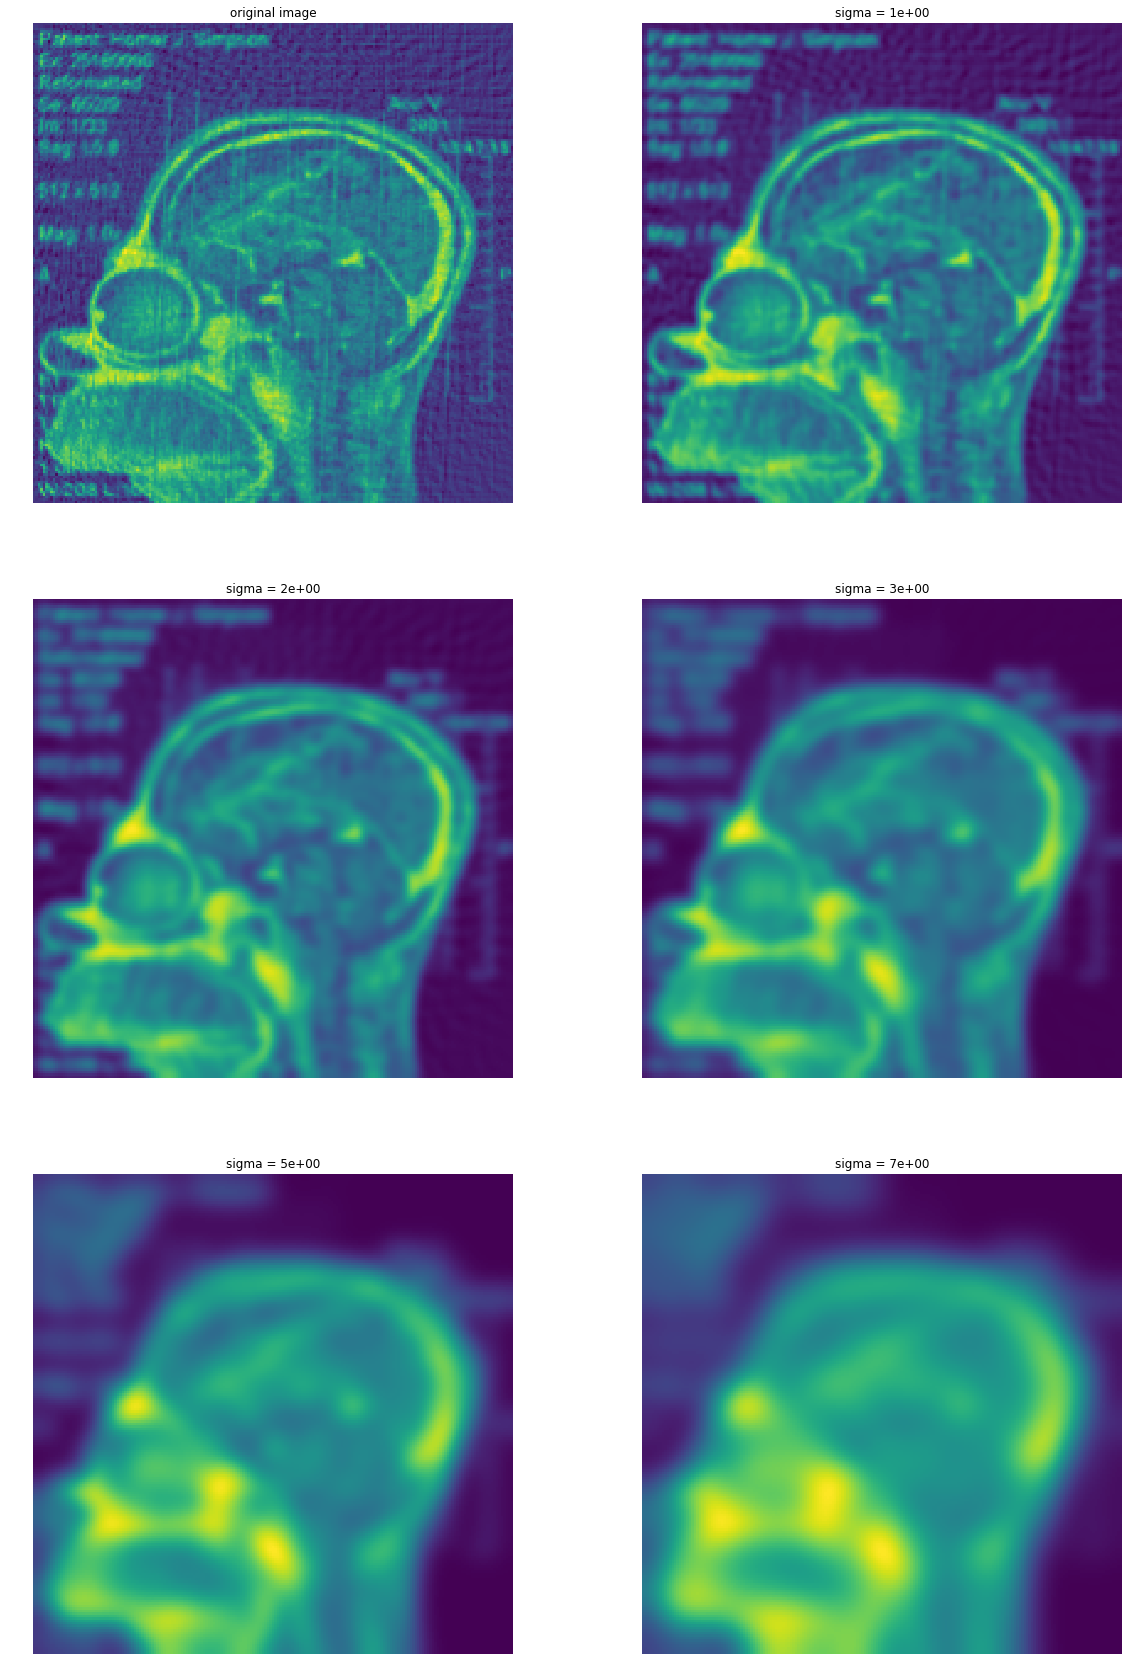

In [298]:
plt.figure(figsize=[20,30])
gs = mpl.gridspec.GridSpec(3, 2)

for i in range(6):
    plt.subplot(gs[i])
    if i == 0:
        plt.title('original image')
    else:
        plt.title('sigma = %0.0e' %(sigma[i-1]))
    plt.imshow(b_gauss[i])
    plt.axis('off')

Text(0, 0.5, 'std image')

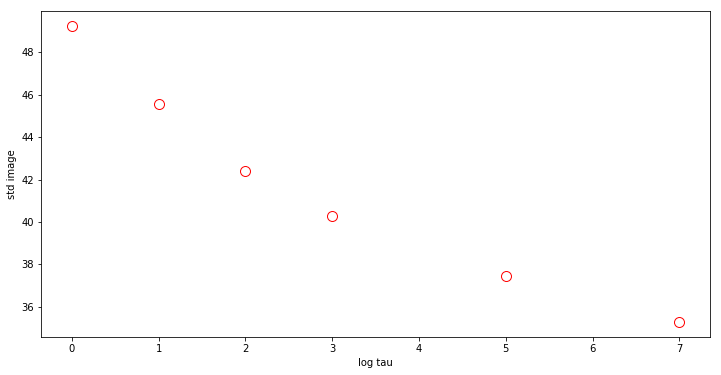

In [309]:
plt.figure(figsize=[12,6])
plt.scatter([0]+sigma,[np.std(b_gauss[i].ravel()) for i in range(6)],s=100,facecolor='w',edgecolor='r')
plt.xlabel('log tau')
plt.ylabel('std image')

The standard deviation decreases for larger sigma, which signals less noise. In comparison to the ridge regression images, the images smoothed with a gaussian are less sharp but have a larger dynamical range.

## 3 Automatic feature selection for regression

### 3.1 Implement Orthogonal Matching Pursuit

### 3.2 Classification with sparse LDA

### 3.3 One-against-the-rest classication